In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from poppy.zernike import zernike_basis
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)

In [2]:

file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")


   y / x [mm]      -5.400      -5.250      -5.100      -4.950      -4.800  \
0        3.30         NaN         NaN         NaN         NaN         NaN   
1        3.15         NaN         NaN         NaN    -415.203    -402.588   
2        3.00         NaN         NaN         NaN    -402.621    -389.987   
3        2.85         NaN         NaN         NaN    -388.188    -375.600   
4        2.70         NaN         NaN         NaN    -374.016    -361.513   

       -4.650      -4.500      -4.350      -4.200  ...       4.200  \
0         NaN         NaN         NaN         NaN  ...         NaN   
1    -390.227    -378.177    -366.438    -355.010  ...      52.263   
2    -377.625    -365.574    -353.838    -342.419  ...      56.518   
3    -363.318    -351.346    -339.690    -328.353  ...      62.579   
4    -349.312    -337.419    -325.842    -314.582  ...      68.680   

        4.350       4.500       4.650       4.800       4.950       5.100  \
0         NaN         NaN         NaN  

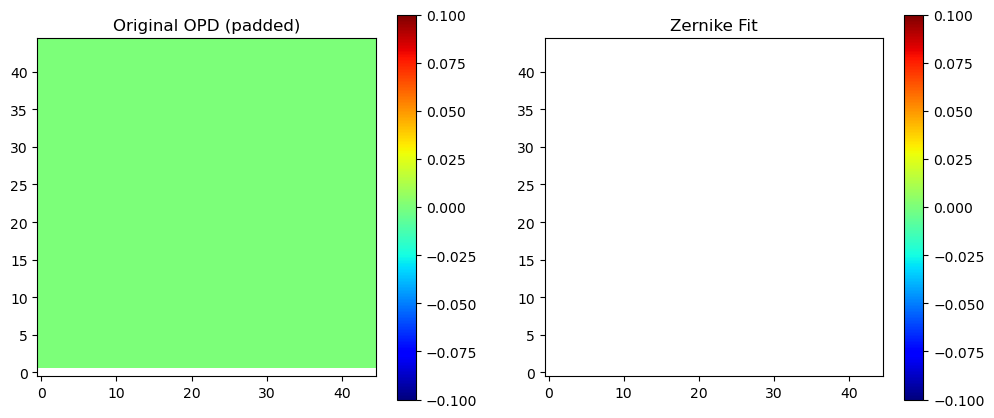

OPD stats: nan nan nan 45


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from poppy.zernike import decompose_opd, zernike_basis

directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]

if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[0]  # picks the Nth CSV file found
full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
print(data.head())


# --- Extract relevant columns ---
# Assuming columns are ordered: spot_x, spot_y, centroid_x, centroid_y, reference_x, reference_y
spot_x = pd.to_numeric(data.iloc[:, 0], errors='coerce').to_numpy()
spot_y = pd.to_numeric(data.iloc[:, 1], errors='coerce').to_numpy()
centroid_x = pd.to_numeric(data.iloc[:, 2], errors='coerce').to_numpy()
centroid_y = pd.to_numeric(data.iloc[:, 3], errors='coerce').to_numpy()
reference_x = pd.to_numeric(data.iloc[:, 4], errors='coerce').to_numpy()
reference_y = pd.to_numeric(data.iloc[:, 5], errors='coerce').to_numpy()


# --- Parameters ---
focal_length = 0.003  # lenslet focal length in meters (adjust as needed)

# --- Calculate slopes ---
slope_x = (centroid_x - reference_x) / focal_length
slope_y = (centroid_y - reference_y) / focal_length

# --- Get unique grid points ---
unique_x = np.unique(spot_x)
unique_y = np.unique(spot_y)

nx = len(unique_x)
ny = len(unique_y)

# --- Reshape slopes to 2D grids ---
slope_x_grid = slope_x.reshape(ny, nx)
slope_y_grid = slope_y.reshape(ny, nx)

# --- Integrate slopes to get OPD ---
def integrate_slopes_fft(slope_x, slope_y):
    ny, nx = slope_x.shape
    kx = np.fft.fftfreq(nx).reshape(1, nx)
    ky = np.fft.fftfreq(ny).reshape(ny, 1)

    denom = (2j * np.pi * kx)**2 + (2j * np.pi * ky)**2
    denom[0, 0] = 1  # Avoid division by zero

    Fx = np.fft.fft2(slope_x)
    Fy = np.fft.fft2(slope_y)

    Fphi = (-2j * np.pi * kx * Fx - 2j * np.pi * ky * Fy) / denom
    Fphi[0, 0] = 0  # Set DC component to zero

    opd = np.real(np.fft.ifft2(Fphi))
    return opd

opd = integrate_slopes_fft(slope_x_grid, slope_y_grid)

# --- Create circular pupil mask ---
N = max(opd.shape)
y, x = np.indices((N, N)) - N//2
r = np.sqrt(x**2 + y**2)
pupil_mask = r <= (N//2)

# --- Pad OPD and mask to square shape (N x N) ---
opd_padded = np.zeros((N, N))
opd_padded[:opd.shape[0], :opd.shape[1]] = opd

pupil_mask_padded = np.zeros((N, N), dtype=bool)
pupil_mask_padded[:opd.shape[0], :opd.shape[1]] = pupil_mask[:opd.shape[0], :opd.shape[1]]

# --- Decompose OPD into Zernike polynomials ---
nterms = 15
coeffs = decompose_opd(opd_padded, pupil_mask_padded, nterms=nterms)

# --- Reconstruct Zernike fit ---
zernikes = zernike_basis(nterms=nterms, npix=N, mask=pupil_mask_padded)
zernike_fit = sum(c * z for c, z in zip(coeffs, zernikes))

# --- Plot results ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

im0 = axs[0].imshow(opd_padded, cmap='jet', origin='lower')
axs[0].set_title('Original OPD (padded)')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(zernike_fit, cmap='jet', origin='lower')
axs[1].set_title('Zernike Fit')
plt.colorbar(im1, ax=axs[1])

plt.show()
print("OPD stats:", np.min(opd), np.max(opd), np.mean(opd), np.isnan(opd).sum())



# Esempio

In [3]:
import zern.zern_core as zern   # import the main library

# import logging
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('text', usetex=False)
cmap = 'jet'

# Parameters
N = 1024      # Number of pixels
N_zern = 50
rho_max = 1.0
randgen = RandomState(12345)  # random seed
# [0] Construct the coordinates and the aperture mask - simple circ
x = np.linspace(-rho_max, rho_max, N)
xx, yy = np.meshgrid(x, x)
rho = np.sqrt(xx ** 2 + yy ** 2)
theta = np.arctan2(xx, yy)
aperture_mask = rho <= rho_max
rho, theta = rho[aperture_mask], theta[aperture_mask]
fig, ax = plt.subplots(1, 1)
img_mask = ax.imshow(aperture_mask, extent=[-rho_max, rho_max, -rho_max, rho_max], cmap="plasma")
ax.set_title(r"Simple aperture mask to calculate Zernike Polynomials")
plt.show()

z = zern.Zernike(mask=aperture_mask)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)

Np, Nz = z.model_matrix_flat.shape
print(f"Zernike class holds a model matrix of shape ({Np}, {Nz})")
print(f"Np = {Np} is the number of non-zero entries in our aperture")
print(f"Nz = {Nz} is the total number of Zernike polynomials modelled!!")

coef = randgen.normal(size=N_zern) / N_zern
phase_map = z.get_zernike(coef)
fig, ax = plt.subplots(1, 1)
MAX = max(np.max(phase_map), -np.min(phase_map))
img = ax.imshow(phase_map, cmap=cmap, vmin=-MAX, vmax=MAX)
plt.colorbar(img)
plt.show()
# z.N_total

z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Standard', normalize_noll=False)
map1 = z.get_zernike(coef)
z.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=False)
map2 = z.get_zernike(coef)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
ax1, ax2 = axes
ax1.imshow(map1, cmap=cmap)
ax2.imshow(map2, cmap=cmap)
ax1.set_title(r"Zernike.Standard")
ax2.set_title(r"Zernike.Jacobi")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

H = zern.invert_model_matrix(z.model_matrix_flat, z.mask)
p = 4
fig, axes = plt.subplots(p, p, figsize=(12, 12))

# Populate a list with the pairs of (n, m) that the Zernike class will use
index_nm = []
r_max = zern.get_limit_index((p+1)**2)
for n in range(r_max):  # Loop over the Zernike index
    for m in np.arange(-n, n + 1, 2):
        index_nm.append([n, m])

# Show the model matrix entries and their associated orders (n,m)
k = 0
for i in range(p):
    for j in range(p):
        _n, _m = index_nm[k]
        ax = axes.flatten()[k]
        img = ax.imshow(H[:, :, k], cmap='jet')
        ax.set_title(f"H({k}) -> Z(n={_n}, m={_m})")
        k += 1

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

n, m = 2, 0
mode = "Jacobi"

z_flat = z.Z_nm(n, m, rho, theta, False, mode)
z_map = zern.invert_mask(z_flat, z.mask)       # Not that we need to unflatten the

fig, ax = plt.subplots(1, 1)
extents = [-rho_max, rho_max, -rho_max, rho_max]
img = ax.imshow(z_map, cmap='jet', extent=extents, vmin=-1, vmax=1)
ax.set_title(r"Zernike $Z_{%d, %d}$" % (n, m))

cbar = plt.colorbar(img)
# img.set_clim(v_min, v_max)
plt.show()

noll = True
z_noll = zern.Zernike(mask=aperture_mask)
z_noll.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=noll)
rms = [np.std(z_noll.model_matrix_flat[:, k]) for k in range(z.N_total)]

fig, ax = plt.subplots(1, 1)
ax.scatter(range(z.N_total), rms)
ax.set_ylim([0.99, 1.01])
ax.grid(True)
ax.set_xlabel("Zernike polynomial $Z_k$")
ax.set_ylabel("RMS wavefront [ ]")
plt.show()

r = np.linspace(0., 1., N)

z_stability = zern.Zernike(mask=aperture_mask)
n = 44
m = 0

r_nm_std = z_stability.R_nm(n, m, r)   # Using 'Standard' recurrence

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_std)
ax.set_xlim([0.8, 1.0])
ax.grid(True)
ax.set_title("Numerical stability issues start to show up for the 'Standard' recurrence")
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")

r_nm_std = z_stability.R_nm(n, m, r)
r_nm_jac = z_stability.R_nm_Jacobi(n, m, r)
err = r_nm_std - r_nm_jac

fig, ax = plt.subplots(1, 1)
ax.plot(r, r_nm_jac, label='Jacobi', c='k')
ax.scatter(r, r_nm_std, label='Standard', c='r', s=5)
ax.set_xlim([0.8, 1.0])
ax.legend(loc=2, title='Zernike recurrence')
ax.set_title("Using mode='Jacobi' maintains numerical stability even at high radial order", fontsize=10)
ax.set_xlabel(r"Radial coordinate $\rho$ []")
ax.set_ylabel(r"Radial Zernike $Z_{n,m}(\rho)$ []")
ax.grid(True)

N_zern = 100
coef = randgen.normal(size=N_zern) / N_zern

z_ls = zern.Zernike(mask=aperture_mask)
z_ls.create_model_matrix(rho, theta, n_zernike=N_zern, mode='Jacobi', normalize_noll=True)

phase_map = z_ls.get_zernike(coef)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(phase_map, cmap='jet')
plt.colorbar(img)
plt.show()

coef1 = randgen.normal(size=N_zern) / N_zern
coef2 = randgen.normal(size=N_zern) / N_zern

map1 = z_ls.get_zernike(coef1)
map2 = z_ls.get_zernike(coef2)
total_map = (map1 + map2)

plt.figure()
plt.imshow(total_map, cmap=cmap)
plt.show()

flat_phase_map = total_map[z_ls.mask]
# Construct the Least-Squares problem
H_f = z_ls.model_matrix_flat
y = np.dot(H_f.T, flat_phase_map)
N = np.dot(H_f.T, H_f)
invN = np.linalg.inv(N)
fit_result_coef = np.dot(invN, y)
fit_map = z_ls.get_zernike(fit_result_coef)
error_map = total_map - fit_map
E_MAX = max(error_map.max(), -error_map.min())

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
img1 = ax1.imshow(total_map, cmap=cmap)
cb1 = plt.colorbar(img1, ax=ax1, fraction=0.046, pad=0.04)
ax1.set_title(r"Original wavefront $\Phi=\phi_1 + \phi_2$")
img2 = ax2.imshow(fit_map, cmap=cmap)
cb2 = plt.colorbar(img2, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_title(r"Least Squares fit $\Psi=(H_t \cdot H)^{-1}(H_t\cdot \Phi)$")
img3 = ax3.imshow(error_map, cmap='coolwarm', vmin=-E_MAX, vmax=E_MAX)
cb3 = plt.colorbar(img3, ax=ax3, fraction=0.046, pad=0.04)
ax3.set_title(r"Error fit")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

ModuleNotFoundError: No module named 'zern.zern_core'

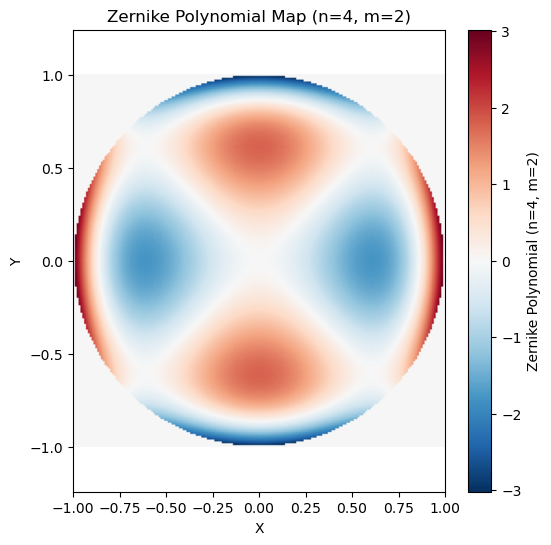

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import poppy

# Create a 2D grid of points in the unit disk
grid_size = 200
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)

# Convert to polar coordinates
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Mask points outside the unit disk
mask = R <= 1

# Initialize Zernike array with zeros
Z = np.zeros_like(R)

# Compute Zernike polynomial only inside the unit disk, pass both rho and theta arrays
Z[mask] = poppy.zernike.zernike(4, 2, rho=R[mask], theta=Theta[mask])

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(Z, extent=(-1, 1, -1, 1), cmap='RdBu_r')
plt.colorbar(label='Zernike Polynomial (n=4, m=2)')
plt.title('Zernike Polynomial Map (n=4, m=2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.show()



In [6]:
import numpy as np
import zern

# Example data: normalized coordinates and function values
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
xx, yy = np.meshgrid(x, y)

# Example function values (replace with your data)
values = np.exp(-(xx**2 + yy**2))

# Flatten arrays for fitting
points = np.vstack([xx.ravel(), yy.ravel()]).T
vals = values.ravel()

# Compute Zernike coefficients up to order n=4
coeffs = zern.zernike_fit(points, vals, n=4)

print("Zernike coefficients:", coeffs)


AttributeError: module 'zern' has no attribute 'zernike_fit'

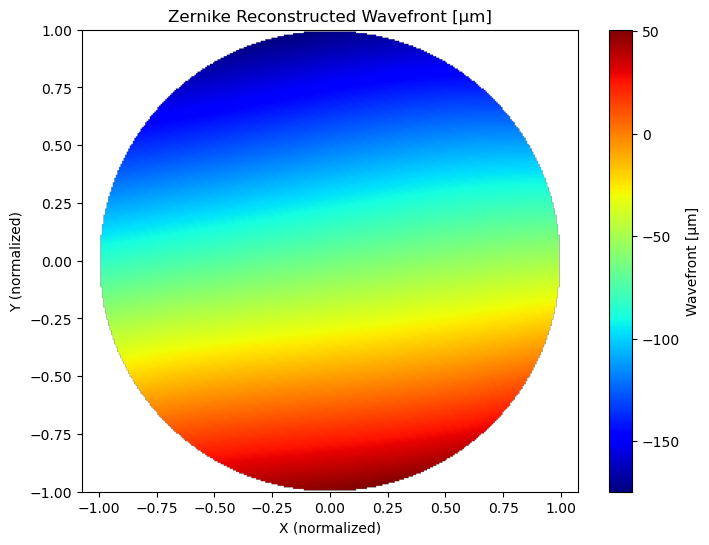

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from poppy.zernike import zernike_basis

# Step 1: Zernike coefficients
coeffs = np.array([
    -64.165,  
     8.010,   
    56.332,   
     0.120,
    -0.622,
    -0.830,
     0.149,
    -0.055,
     0.550,
     0.114,
    -0.025,
    -0.064,
     0.447,
     0.005,
     0.034
])  # in micrometers

# Step 2: Create coordinate grid
N = 300
x = np.linspace(-1, 1, N)
y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)

# Step 3: Mask
mask = R <= 1

# Step 4: Generate Zernike basis (15 modes)
# zernike_basis returns an array of shape (nterms, N, N)
basis_stack = zernike_basis(nterms=15, rho=R, theta=Theta)

# Step 5: Combine modes using coefficients
Z = np.sum(coeffs[:, np.newaxis, np.newaxis] * basis_stack, axis=0)

# Step 6: Apply mask
Z[~mask] = np.nan

# Step 7: Plot
plt.figure(figsize=(8, 6))
plt.imshow(Z, extent=[-1, 1, -1, 1], cmap='jet')
plt.title('Zernike Reconstructed Wavefront [μm]')
plt.xlabel('X (normalized)')
plt.ylabel('Y (normalized)')
plt.colorbar(label='Wavefront [μm]')
plt.axis('equal')
plt.show()





x_coords length: 74
wavefront_data shape: (45, 74)
Mode 1: -3.320530 
Mode 2: 52.888120 
Mode 3: -45.769420 
Mode 4: -0.979901 
Mode 5: 0.043397 
Mode 6: -0.756293 


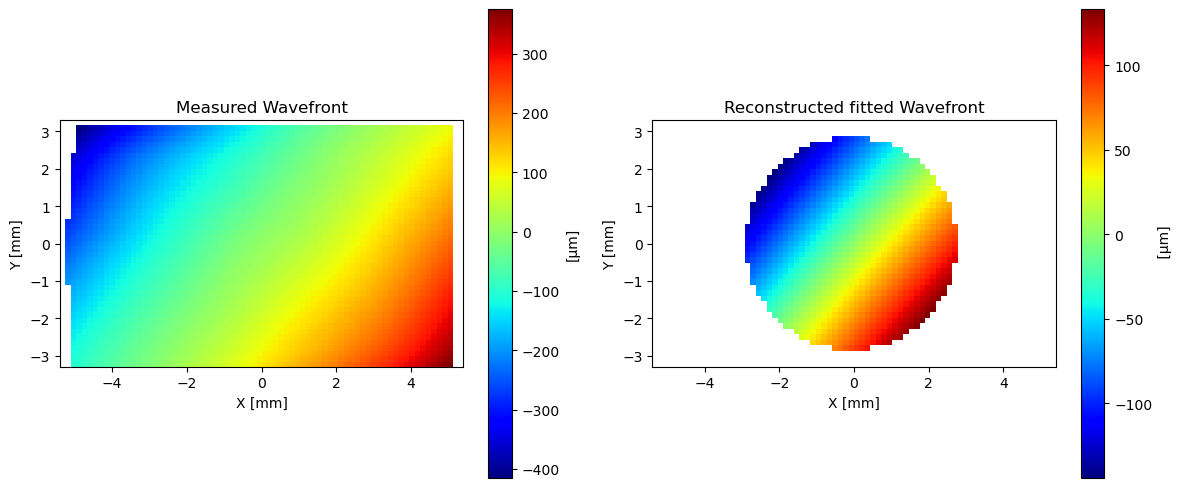

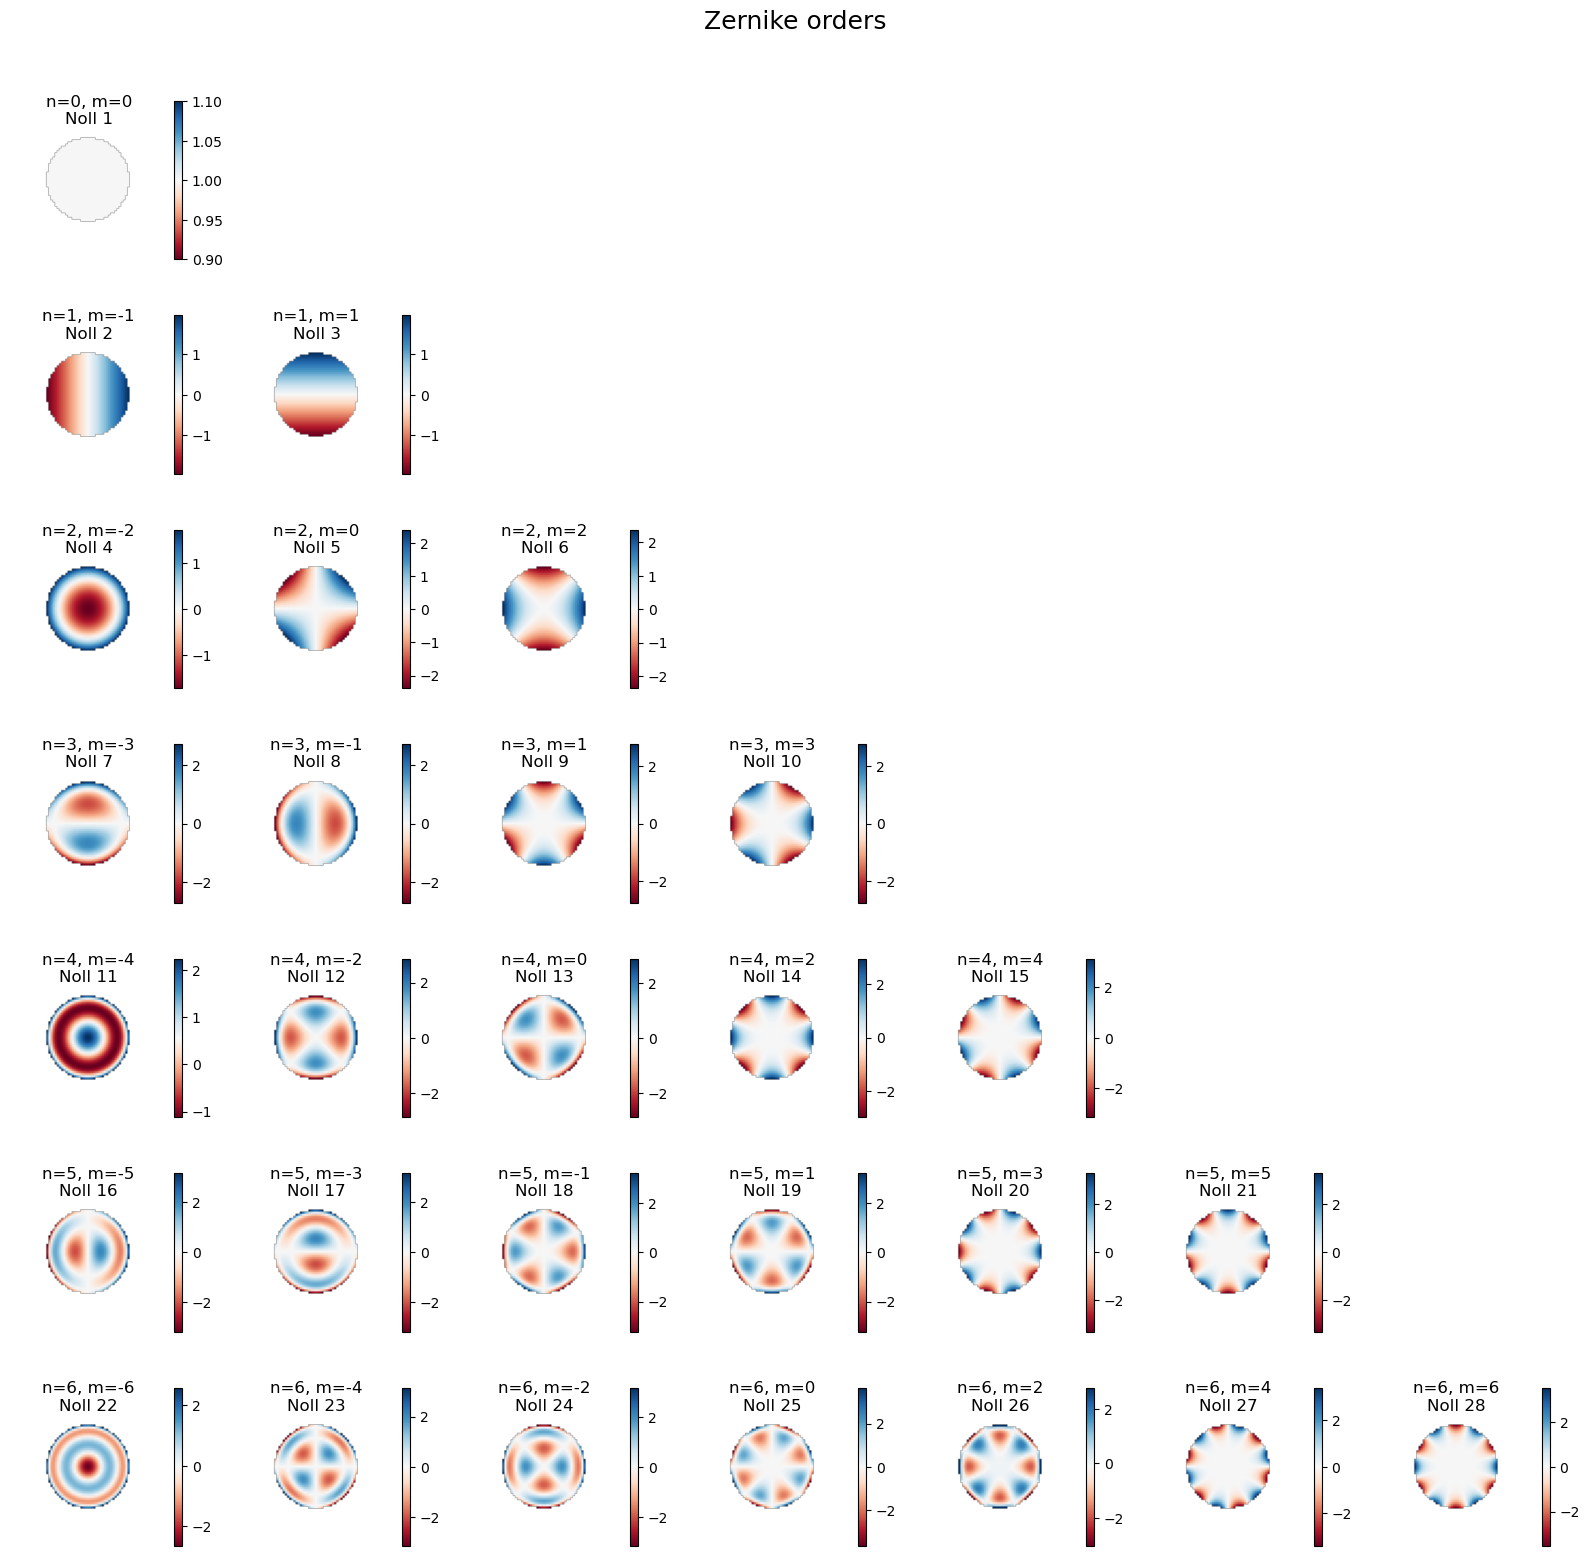

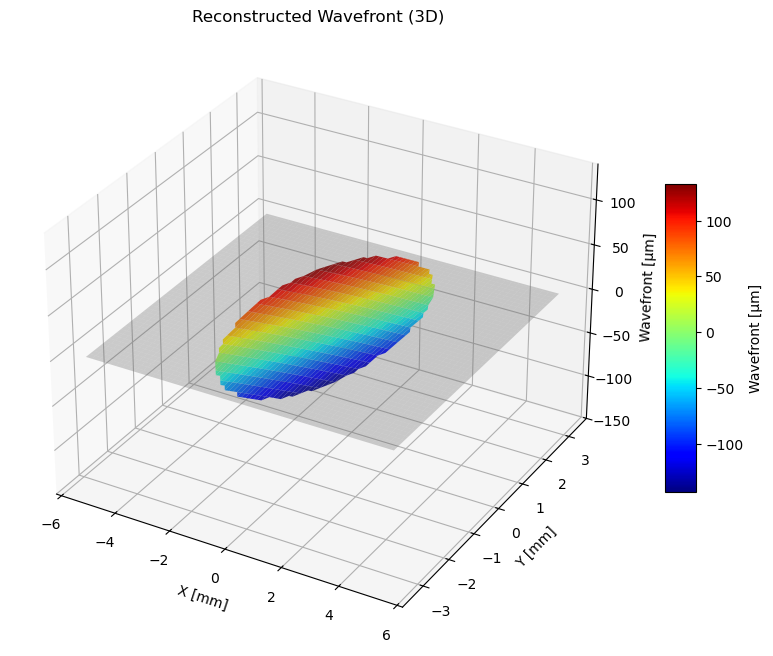

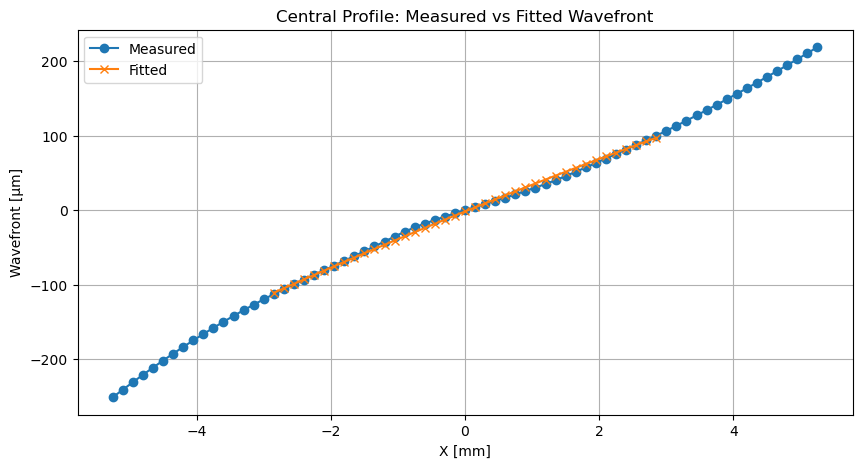

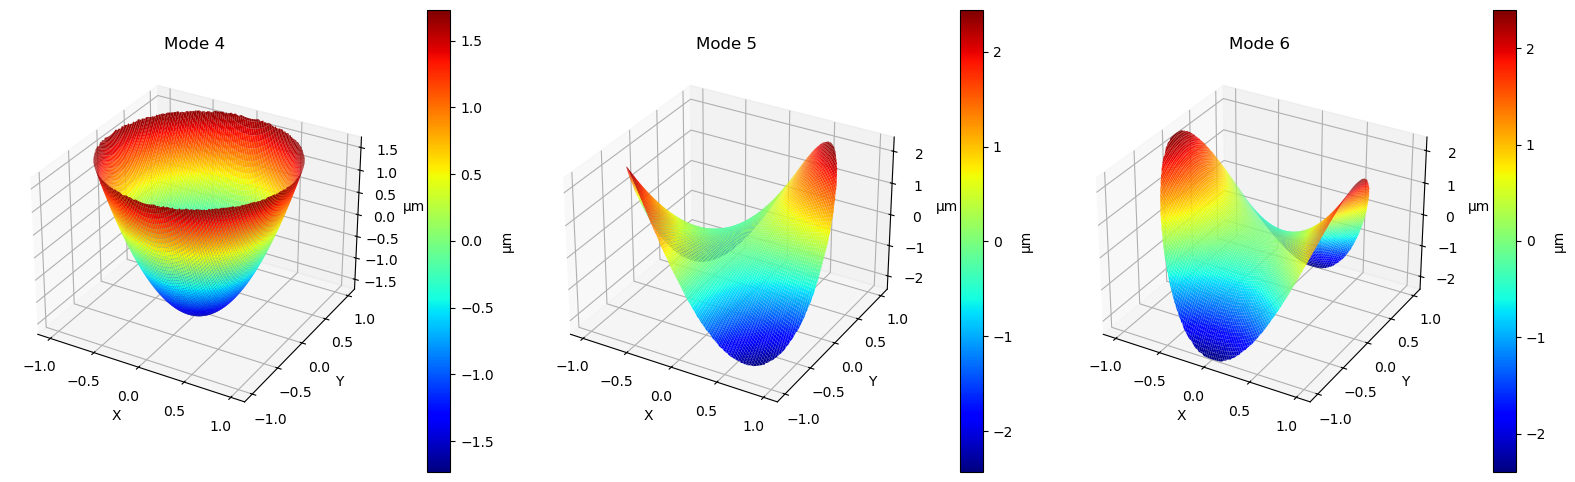

In [27]:
from mpl_toolkits.mplot3d import Axes3D


def noll_to_zernike(j):
    """
    Convert Noll index to (n, m) Zernike indices.
    Noll index j starts from 1.
    Returns (n, m) where n is radial order and m is azimuthal frequency.
    """
    n = 0
    j1 = j - 1
    while j1 >= n + 1:
        n += 1
        j1 -= n
    m = (-n) + 2 * j1
    return n, m


def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    
    # Extract x coords: keep all, converting invalid to NaN if needed
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan)  # fill invalid with nan
    
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue
        
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)
        
        y_coords.append(y)
        wavefront_data.append(vals)
    
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)

    print(f"x_coords length: {len(x_coords)}")
    print(f"wavefront_data shape: {wf_array.shape}")

    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")

    return x_coords, y_coords, wf_array




def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)

    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)

    mask = R <= 1
    wf_masked = wavefront_data[mask]

    # Generate all Zernike modes
    # basis_stack.shape == (max_mode, R.shape[0], R.shape[1])
    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)

    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T

    # Fit coefficients with least squares
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)

    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals

    return coeffs, wf_fit



def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()

######################################################################################################
file = (r"C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\febbraio\Seginus")
directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]

if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[0]  # sceglie il file N trovato nella cartella (solo file CSV, per fare riferimento a quelli della cartella ricordare che il conteggio qui inzia da 0)

full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
#print(data.head())

filename = full_path  
pupil_diameter = 5.8  # mm
max_mode = 6
#######################################################################################################


x_coords, y_coords, wavefront_data = parse_wavefront_grid(filename)
coeffs, wavefront_fit = fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode)

for i, c in enumerate(coeffs, 1):
    print(f"Mode {i}: {c:.6f} ")#µm")

plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit)


#  Zernike modes (n=6)
orders = 6
# Number of Zernike modes up to n=6: (n+1)(n+2)/2 = 28
n_modes = (orders + 1) * (orders + 2) // 2

X_norm = x_coords / (pupil_diameter / 2)
Y_norm = y_coords / (pupil_diameter / 2)
X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
R = np.sqrt(X_mesh**2 + Y_mesh**2)
Theta = np.arctan2(Y_mesh, X_mesh)
mask = R <= 1

basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)

fig, axs = plt.subplots(orders + 1, orders + 1, figsize=(16, 16))
fig.suptitle("Zernike orders", fontsize=18)
for noll in range(1, n_modes + 1):
    n, m = noll_to_zernike(noll)
    row = n
    col = (m + n) // 2
    ax = axs[row, col]
    zern = np.full_like(R, np.nan)
    zern[mask] = basis_stack[noll - 1][mask]
    im = ax.imshow(zern, extent=[np.nanmin(x_coords), np.nanmax(x_coords), np.nanmin(y_coords), np.nanmax(y_coords)],
                   origin='upper', cmap='RdBu')
    ax.set_title(f"n={n}, m={m}\nNoll {noll}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Hide unused subplots
for i in range(orders + 1):
    for j in range(orders + 1):
        if axs[i, j].has_data():
            continue
        axs[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

X, Y = np.meshgrid(x_coords, y_coords)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, wavefront_fit, cmap='jet', edgecolor='none')
ax.set_title('Reconstructed Wavefront (3D)')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Wavefront [μm]')
fig.colorbar(surf, shrink=0.5, aspect=10, label='Wavefront [μm]')

# Add a horizontal plane at z=0
x_plane = np.linspace(np.nanmin(x_coords), np.nanmax(x_coords), 100)
y_plane = np.linspace(np.nanmin(y_coords), np.nanmax(y_coords), 100)
X_plane, Y_plane = np.meshgrid(x_plane, y_plane)
Z_plane = np.zeros_like(X_plane)
ax.plot_surface(X_plane, Y_plane, Z_plane, color='gray', alpha=0.3, edgecolor='none')

plt.show()

# Plot a central profile (e.g., along the middle row)
mid_y_idx = len(y_coords) // 2

plt.figure(figsize=(10, 5))
plt.plot(x_coords, wavefront_data[mid_y_idx], label='Measured', marker='o')
plt.plot(x_coords, wavefront_fit[mid_y_idx], label='Fitted', marker='x')
plt.xlabel('X [mm]')
plt.ylabel('Wavefront [μm]')
plt.title('Central Profile: Measured vs Fitted Wavefront')
plt.legend()
plt.grid(True)
plt.show()



##################### 3D PLOTS OF ZERNIKE MODES ##########################

#####################################################################
grid_size = 300
modes = [4, 5,6]  # Noll indices 
#############################################################
x = np.linspace(-1, 1, grid_size)
y = np.linspace(-1, 1, grid_size)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
Theta = np.arctan2(Y, X)
mask = R <= 1.0
basis_stack = zernike_basis(nterms=max(modes), rho=R, theta=Theta)


fig = plt.figure(figsize=(16, 8))
for i, mode in enumerate(modes, 1):
    Z = np.full_like(R, np.nan)
    Z[mask] = basis_stack[mode-1][mask]  # nan outside the pupil

    ax = fig.add_subplot(1, len(modes), i, projection='3d')
    # Only plot points inside the pupil
    # The 'mask' argument is not valid for plot_surface; use nan-masked Z instead
    surf = ax.plot_surface(
        X, Y, Z,
        rstride=3, cstride=3,
        cmap='jet',
        linewidth=0, antialiased=True
    )
    ax.set_title(f'Mode {mode}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('µm')
    ax.set_zlim(np.nanmin(Z), np.nanmax(Z))
    fig.colorbar(surf, ax=ax, shrink=0.6, pad=0.1, label='µm')

plt.tight_layout()
plt.show()

# Wavefront dal file CSV

Found Zernike coefficients: [-104.397, 47.116, 57.991, -0.14, -0.676, -0.849]
Using Zernike coefficients: [-104.397   47.116   57.991   -0.14    -0.676   -0.849]


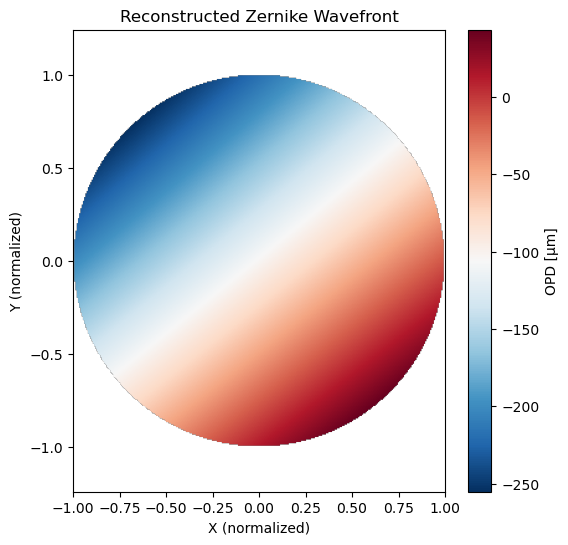

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from poppy.zernike import zernike_basis

##########################################################################################
directory = file
files = [f for f in os.listdir(directory) if f.endswith('.csv')]
if not files:
    raise FileNotFoundError('No CSV files found in directory')

filename = files[0]  # picks the Nth CSV file 
full_path = os.path.join(directory, filename)
data = pd.read_csv(full_path, encoding='latin1', comment='#', on_bad_lines='skip',skiprows = 100)  # skip lines starting with #
####################################################################################################

def parse_zernike_coeffs(filename, n_modes=15):
    """Read the ‘*** ZERNIKE FIT ***’ section and return the first n_modes coefficients."""
    coeffs = []
    with open(filename, 'r', encoding='latin-1') as f:
        in_section = False
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_section = True
                continue
            if in_section:
                # look for lines like: "   1,     0,     0,      -64.165"
                m = re.match(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)', line)
                if m:
                    idx = int(m.group(1))
                    coef = float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(coef)
                # break out once we have all modes or hit next section
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise ValueError(f"Found only {len(coeffs)} coefficients, expected {n_modes}")
    print("Found Zernike coefficients:", coeffs)
    return np.array(coeffs)

def reconstruct_from_coeffs(coeffs, grid_size=300):
    
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    mask = R <= 1.0

    # get all modes up to len(coeffs)
    basis = zernike_basis(nterms=len(coeffs), rho=R, theta=Theta)

    # sum up weighted modes
    W = np.zeros_like(R)
    for j, c in enumerate(coeffs):
        W += c * basis[j]
    W[~mask] = np.nan
    return x, y, W

def plot_wavefront(x, y, W, title='Reconstructed Zernike Wavefront'):
    plt.figure(figsize=(6,6))
    plt.imshow(W, extent=[x.min(), x.max(), y.min(), y.max()],
               origin='upper', cmap='RdBu_r')
    plt.colorbar(label='OPD [µm]')
    plt.title(title)
    plt.xlabel('X (normalized)')
    plt.ylabel('Y (normalized)')
    plt.axis('equal')
    plt.show()


filename = full_path
n_modes = 6 
coeffs = parse_zernike_coeffs(filename, n_modes=n_modes)
print("Using Zernike coefficients:", coeffs)
x, y, W = reconstruct_from_coeffs(coeffs, grid_size=300)
plot_wavefront(x, y, W)


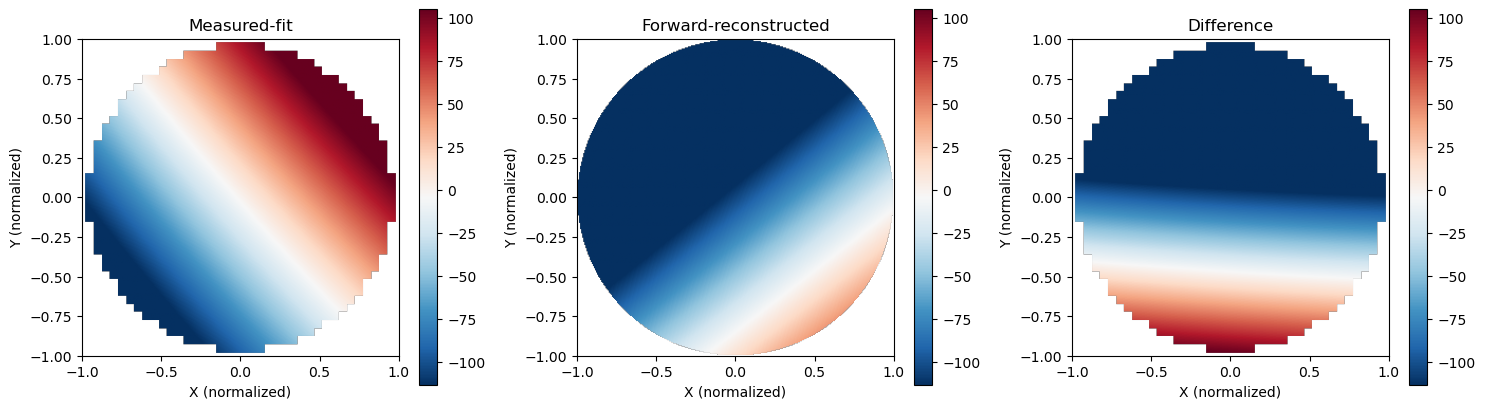

In [ ]:
def parse_zernike_coeffs(filename, n_modes=15):
    """Read the ‘*** ZERNIKE FIT ***’ section and return the first n_modes coefficients."""
    coeffs = []
    with open(filename, 'r', encoding='latin-1') as f:
        in_section = False
        for line in f:
            if line.strip().startswith('*** ZERNIKE FIT ***'):
                in_section = True
                continue
            if in_section:
                # look for lines like: "   1,     0,     0,      -64.165"
                m = re.match(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)', line)
                if m:
                    idx = int(m.group(1))
                    coef = float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(coef)
                # break out once we have all modes or hit next section
                if len(coeffs) >= n_modes:
                    break
    if len(coeffs) < n_modes:
        raise ValueError(f"Found only {len(coeffs)} coefficients, expected {n_modes}")
    print("Found Zernike coefficients:", coeffs)
    return np.array(coeffs)


def reconstruct_wavefront_from_coeffs(coeffs, grid_size):

    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    Theta = np.arctan2(Y, X)
    mask = R <= 1

    basis = zernike_basis(nterms=len(coeffs), rho=R, theta=Theta)
    W = np.zeros_like(R)
    for j, c in enumerate(coeffs):
        W += c * basis[j]
    W[~mask] = np.nan
    return x, y, W


grid_size = 300


xv, yv = np.linspace(-1,1,grid_size), np.linspace(-1,1,grid_size)
Xv, Yv = np.meshgrid(xv, yv)

from scipy.interpolate import RegularGridInterpolator

x_norm = (x_coords - x_coords.mean())/(pupil_diameter/2)
y_norm = (y_coords - y_coords.mean())/(pupil_diameter/2)
# Remove nan values from x_coords and corresponding columns in wavefront_fit
valid_x = ~np.isnan(x_coords)
valid_y = ~np.isnan(y_coords)  # In your data y_coords seems fine, but let's be safe

x_coords_clean = x_coords[valid_x]
y_coords_clean = y_coords[valid_y]
wavefront_fit_clean = wavefront_fit[np.ix_(valid_y, valid_x)]

# Now normalize
x_norm = (x_coords_clean - x_coords_clean.mean()) / (pupil_diameter / 2)
y_norm = (y_coords_clean - y_coords_clean.mean()) / (pupil_diameter / 2)

# Interpolator
interp = RegularGridInterpolator(
    (y_norm, x_norm),
    wavefront_fit_clean,
    bounds_error=False,
    fill_value=np.nan
)
W_meas = interp(np.stack([Yv.ravel(), Xv.ravel()], axis=1)).reshape(grid_size, grid_size)
_, _, W_known = reconstruct_wavefront_from_coeffs(coeffs, grid_size)

# === 3) Plot side by side ===
fig, axs = plt.subplots(1,3,figsize=(15,5), subplot_kw={'aspect':'equal'})
for ax, W, title in zip(axs,
                        [W_meas, W_known, W_known - W_meas],
                        ['Measured‐fit', 'Forward‐reconstructed', 'Difference']):
    im = ax.imshow(W,
                   extent=[-1,1,-1,1],
                   origin='upper',
                   cmap='RdBu_r',
                   vmin=np.nanpercentile(W_meas,5),
                   vmax=np.nanpercentile(W_meas,95))
    ax.set_title(title)
    ax.set_xlabel('X (normalized)')
    ax.set_ylabel('Y (normalized)')
    fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()
